Nuestro cliente nos pide que le digamos el precio al que podemos esperar vender las 3 últimas viviendas que acaban de entrar en la base de datos, y con qué margen de seguridad nos movemos.  
Para ello, nos dan los datos de las viviendas que tienen en su base de datos.

# Imports

Librerias

In [ ]:
pip install catboost

In [ ]:
pip install shap

In [ ]:
# gestión de datos
import numpy as np
import pandas as pd

# fechas
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# metricas
import sklearn.metrics as metrics

# interpretabilidad
import shap

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

Datos

In [ ]:
# conexion a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# carga de los datos en un dataframe
df = pd.read_csv('/content/drive/MyDrive/TIC/Data science/Master Data Science Nuclio - profesor/Aprendizaje supervisado - Presencial/Ejercicios/Regresion - ejemplo basico - viviendas/viviendas_regresion_basica.csv')

# Business Understanding​

In [ ]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0,1.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0,1.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0,1.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0,1.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6998,viv_6999,128.0,3,5,1979-01-01,NaN,0,1.3,317000.0,31700.0,0.0
6999,viv_7000,77.0,4+,7,1996-01-01,ext,0,1.5,177000.0,17700.0,0.0
7000,viv_7001,128.0,3,6,2022-01-01,ext,0,0.7,NaN,NaN,NaN
7001,viv_7002,93.0,4+,9,1988-01-01,NaN,0,1.5,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7003 entries, 0 to 7002
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_vivienda  7003 non-null   object 
 1   superficie   6993 non-null   float64
 2   num_hab      7003 non-null   object 
 3   distancia    7003 non-null   int64  
 4   fecha_const  7003 non-null   object 
 5   parking      4764 non-null   object 
 6   premiada     7003 non-null   int64  
 7   tam_buzon    7003 non-null   float64
 8   precio       7000 non-null   float64
 9   impuestos    7000 non-null   float64
 10  vendida      7000 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 601.9+ KB


In [ ]:
df_predecir = df[df['precio'].isnull()]
df_predecir

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
7000,viv_7001,128.0,3,6,2022-01-01,ext,0,0.7,NaN,NaN,NaN
7001,viv_7002,93.0,4+,9,1988-01-01,NaN,0,1.5,NaN,NaN,NaN
7002,viv_7003,68.0,2,3,1972-01-01,NaN,0,0.7,NaN,NaN,NaN


In [ ]:
# quitamos las 3 viviendas a predecir
df = df[df['precio'].isnull() == False]
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0,1.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0,1.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0,1.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0,1.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6995,viv_6996,98.0,2,2,2006-01-01,int,0,1.8,342000.0,34200.0,0.0
6996,viv_6997,111.0,4+,2,1981-01-01,ext,0,0.9,121000.0,12100.0,0.0
6997,viv_6998,76.0,3,4,2009-01-01,ext,0,0.6,250000.0,25000.0,0.0
6998,viv_6999,128.0,3,5,1979-01-01,NaN,0,1.3,317000.0,31700.0,0.0


In [ ]:
# quitamos las viviendas que no se han vendido
df = df[df['vendida']==1]
df = df.drop('vendida', axis=1)
df_predecir = df_predecir.drop('vendida', axis=1)

In [ ]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0
...,...,...,...,...,...,...,...,...,...,...
6987,viv_6988,130.0,3,7,1996-01-01,NaN,0,1.9,286000.0,28600.0
6988,viv_6989,120.0,3,8,2022-01-01,ext,0,1.0,299000.0,29900.0
6989,viv_6990,76.0,4+,7,2006-01-01,ext,0,0.5,245000.0,24500.0
6992,viv_6993,128.0,3,8,2022-01-01,NaN,0,1.3,276000.0,27600.0


In [ ]:
df_predecir = df_predecir.drop('precio', axis=1)

# Análisis exploratorio

In [ ]:
df.nunique()

id_vivienda    5000
superficie       71
num_hab           4
distancia        10
fecha_const      60
parking           2
premiada          2
tam_buzon        16
precio          217
impuestos       217
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
superficie,4990.0,96.931663,20.044797,60.0,80.0,98.0,114.0,130.0
distancia,5000.0,5.410600,2.786245,1.0,3.0,5.0,8.0,10.0
premiada,5000.0,0.000200,0.014142,0.0,0.0,0.0,0.0,1.0
tam_buzon,5000.0,1.243360,0.432117,0.5,0.9,1.2,1.6,2.0
precio,5000.0,245552.600000,47504.380498,129000.0,209000.0,243000.0,282000.0,350000.0
impuestos,5000.0,24555.260000,4750.438050,12900.0,20900.0,24300.0,28200.0,35000.0


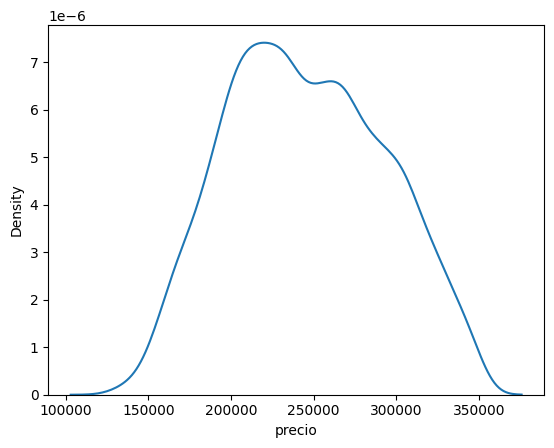

In [ ]:
sns.kdeplot(data=df, x='precio')
plt.show()

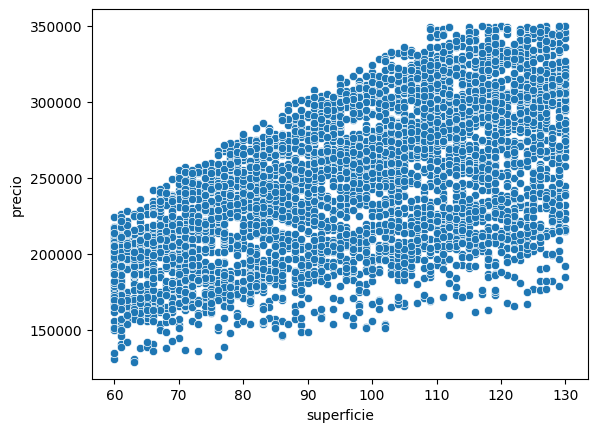

In [ ]:
sns.scatterplot(data=df, x='superficie', y='precio')
plt.show()

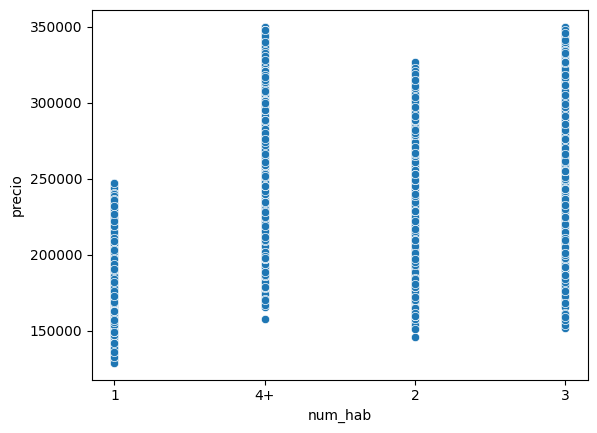

In [ ]:
sns.scatterplot(data=df, x='num_hab', y='precio')
plt.show()

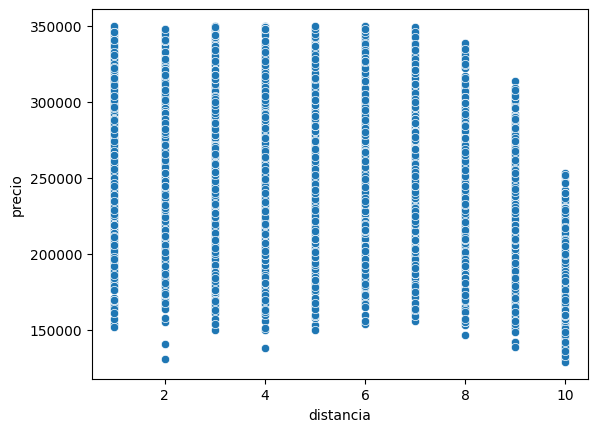

In [ ]:
sns.scatterplot(data=df, x='distancia', y='precio')
plt.show()

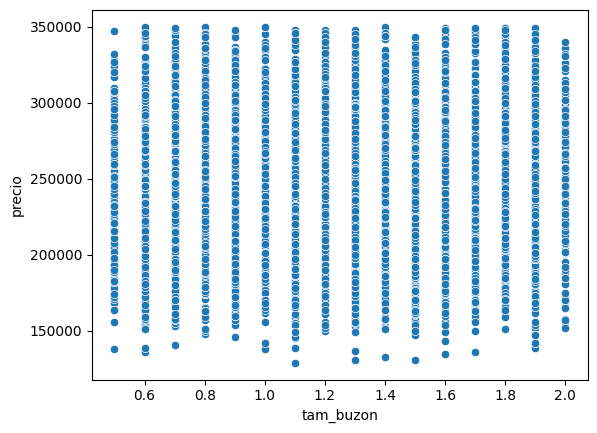

In [ ]:
sns.scatterplot(data=df, x='tam_buzon', y='precio')
plt.show()

# Preprocessing

## data cleaning

In [ ]:
# comprobamos duplicados
df.duplicated().sum()

0

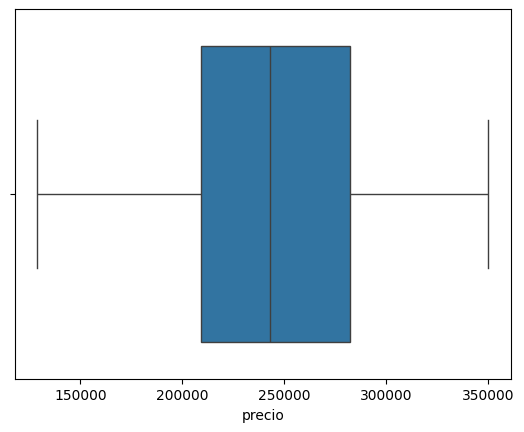

In [ ]:
# comprobamos outliers
sns.boxplot(data=df, x='precio')
plt.show()

## gestión de los nulos

In [ ]:
df.isnull().sum()

id_vivienda       0
superficie       10
num_hab           0
distancia         0
fecha_const       0
parking        1580
premiada          0
tam_buzon         0
precio            0
impuestos         0
dtype: int64

parking

In [ ]:
df['parking'].unique()

array(['ext', nan, 'int'], dtype=object)

In [ ]:
df['parking'].value_counts()

parking
ext    1748
int    1672
Name: count, dtype: int64

Interpretamos el nulo en la columna parking como la ausencia de parking en la vivienda, no como la ausencia de datos.  
Imputaremos el valor 'sin'.

In [ ]:
df['parking'] = df['parking'].fillna('sin')
df_predecir['parking'] = df_predecir['parking'].fillna('sin')

superficie

Solo son 10 viviendas sin datos: los eliminamos.

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum().sum()

0

## gestión de las variables categóricas

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4990 entries, 0 to 6994
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_vivienda  4990 non-null   object 
 1   superficie   4990 non-null   float64
 2   num_hab      4990 non-null   object 
 3   distancia    4990 non-null   int64  
 4   fecha_const  4990 non-null   object 
 5   parking      4990 non-null   object 
 6   premiada     4990 non-null   int64  
 7   tam_buzon    4990 non-null   float64
 8   precio       4990 non-null   float64
 9   impuestos    4990 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 428.8+ KB


id_vivienda

In [ ]:
df = df.drop('id_vivienda', axis=1)

id_viv_predecir = df_predecir['id_vivienda']
df_predecir = df_predecir.drop('id_vivienda', axis=1)

superficie



In [ ]:
df['superficie'] = df['superficie'].astype('int64')
df_predecir['superficie'] = df_predecir['superficie'].astype('int64')

num_hab

In [ ]:
df['num_hab'].unique()

array(['1', '4+', '2', '3'], dtype=object)

-> Vamos a cambiar el '4+' por 4

In [ ]:
df['num_hab'] = df['num_hab'].apply(lambda x: 4 if x == '4+' else int(x))
df_predecir['num_hab'] = df_predecir['num_hab'].apply(lambda x: 4 if x == '4+' else int(x))

fecha_const

-> vamos a cambiar la fecha de construcción por la edad en años

In [ ]:
df['fecha_const'] = pd.to_datetime(df['fecha_const'])
df_predecir['fecha_const'] = pd.to_datetime(df_predecir['fecha_const'])

In [ ]:
hoy = pd.Timestamp(dt.date.today())
hoy

Timestamp('2024-05-25 00:00:00')

In [ ]:
df['edad'] = hoy - df['fecha_const']
df_predecir['edad'] = hoy - df_predecir['fecha_const']

In [ ]:
df['edad'] = df['edad'].dt.days
df_predecir['edad'] = df_predecir['edad'].dt.days

In [ ]:
df['edad'] = df['edad'] / 365
df_predecir['edad'] = df_predecir['edad'] / 365

In [ ]:
df['edad'] = df['edad'].round(0)
df_predecir['edad'] = df_predecir['edad'].round(0)

In [ ]:
df['edad'] = df['edad'].astype('int64')
df_predecir['edad'] = df_predecir['edad'].astype('int64')

In [ ]:
df = df.drop('fecha_const', axis=1)
df_predecir = df_predecir.drop('fecha_const', axis=1)

parking

In [ ]:
df['parking'].value_counts()

parking
ext    1742
int    1668
sin    1580
Name: count, dtype: int64

-> se tratará con one hot encoding: crea una columna booleana por cada categoría

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4990 entries, 0 to 6994
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   superficie  4990 non-null   int64  
 1   num_hab     4990 non-null   int64  
 2   distancia   4990 non-null   int64  
 3   parking     4990 non-null   object 
 4   premiada    4990 non-null   int64  
 5   tam_buzon   4990 non-null   float64
 6   precio      4990 non-null   float64
 7   impuestos   4990 non-null   float64
 8   edad        4990 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 389.8+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
superficie,4990.0,96.931663,20.044797,60.0,80.0,98.0,114.0,130.0
num_hab,4990.0,2.605411,1.075805,1.0,2.0,3.0,4.0,4.0
distancia,4990.0,5.408417,2.786865,1.0,3.0,5.0,8.0,10.0
premiada,4990.0,0.000200,0.014156,0.0,0.0,0.0,0.0,1.0
tam_buzon,4990.0,1.243507,0.431958,0.5,0.9,1.2,1.6,2.0
precio,4990.0,245515.230461,47513.575494,129000.0,209000.0,243000.0,282000.0,350000.0
impuestos,4990.0,24551.523046,4751.357549,12900.0,20900.0,24300.0,28200.0,35000.0
edad,4990.0,30.173547,17.166837,1.0,15.0,30.0,45.0,60.0


## one hot encoding

In [ ]:
df = pd.get_dummies(df)
df_predecir = pd.get_dummies(df_predecir)

In [ ]:
df

,superficie,num_hab,distancia,premiada,tam_buzon,precio,impuestos,edad,parking_ext,parking_int,parking_sin
0,65,1,7,0,0.9,166000.0,16600.0,33,True,False,False
1,97,4,8,0,1.8,279000.0,27900.0,30,True,False,False
2,80,4,4,0,1.0,233000.0,23300.0,54,False,False,True
3,73,1,1,0,1.1,182000.0,18200.0,41,True,False,False
4,86,2,8,0,1.2,210000.0,21000.0,25,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
6987,130,3,7,0,1.9,286000.0,28600.0,28,False,False,True
6988,120,3,8,0,1.0,299000.0,29900.0,2,True,False,False
6989,76,4,7,0,0.5,245000.0,24500.0,18,True,False,False
6992,128,3,8,0,1.3,276000.0,27600.0,2,False,False,True


In [ ]:
df_predecir

,superficie,num_hab,distancia,premiada,tam_buzon,impuestos,edad,parking_ext,parking_sin
7000,128,3,6,0,0.7,NaN,2,True,False
7001,93,4,9,0,1.5,NaN,36,False,True
7002,68,2,3,0,0.7,NaN,52,False,True


In [ ]:
df_predecir['parking_int'] = False

In [ ]:
df_predecir

,superficie,num_hab,distancia,premiada,tam_buzon,impuestos,edad,parking_ext,parking_sin,parking_int
7000,128,3,6,0,0.7,NaN,2,True,False,False
7001,93,4,9,0,1.5,NaN,36,False,True,False
7002,68,2,3,0,0.7,NaN,52,False,True,False


In [ ]:
columnas = list(df.columns)
columnas.remove('precio')
df_predecir = df_predecir[columnas]
df_predecir

,superficie,num_hab,distancia,premiada,tam_buzon,impuestos,edad,parking_ext,parking_int,parking_sin
7000,128,3,6,0,0.7,NaN,2,True,False,False
7001,93,4,9,0,1.5,NaN,36,False,False,True
7002,68,2,3,0,0.7,NaN,52,False,False,True


In [ ]:
df.shape

(4990, 11)

In [ ]:
df_predecir.shape

(3, 10)

## alta correlación y baja varianza

alta correlación

In [ ]:
df_corr = df.corr(numeric_only=True)

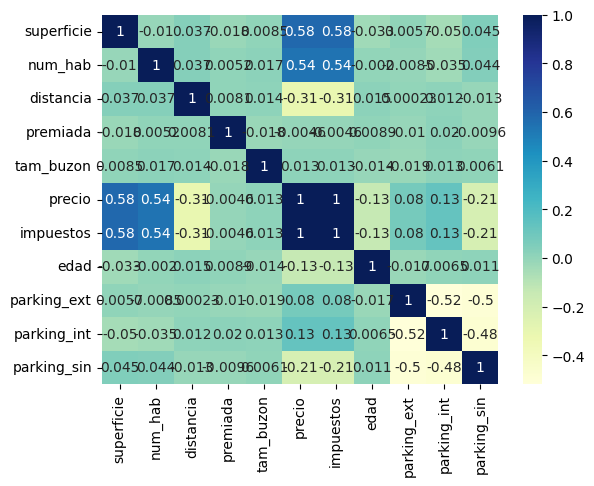

In [ ]:
sns.heatmap(data=df_corr, annot=True, cmap='YlGnBu')
plt.show()

-> los impuestos estan totalmente correlacionados con la target (es un 10%): se eliminan

In [ ]:
df = df.drop('impuestos', axis=1)
df_predecir = df_predecir.drop('impuestos', axis=1)

baja varianza

In [ ]:
df.var(numeric_only=True)

superficie     4.017939e+02
num_hab        1.157357e+00
distancia      7.766616e+00
premiada       2.004008e-04
tam_buzon      1.865874e-01
precio         2.257540e+09
edad           2.947003e+02
parking_ext    2.272742e-01
parking_int    2.225777e-01
parking_sin    2.164200e-01
dtype: float64

In [ ]:
for col in df.columns:
  print(col)
  if col != 'parking':
    print(df[col].var())
    if df[col].var() < 0.01:
      print('baja varianza')
  print('-------------------------')

superficie
401.7938859880515
-------------------------
num_hab
1.1573569668902852
-------------------------
distancia
7.766615853474839
-------------------------
premiada
0.0002004008016032064
baja varianza
-------------------------
tam_buzon
0.1865874177699958
-------------------------
precio
2257539856.180591
-------------------------
edad
294.70028226426797
-------------------------
parking_ext
0.22727419159826973
-------------------------
parking_int
0.22257768694333951
-------------------------
parking_sin
0.21642001180151443
-------------------------


In [ ]:
df['premiada'].value_counts()

premiada
0    4989
1       1
Name: count, dtype: int64

In [ ]:
df = df.drop('premiada', axis=1)
df_predecir = df_predecir.drop('premiada', axis=1)

In [ ]:
df

,superficie,num_hab,distancia,tam_buzon,precio,edad,parking_ext,parking_int,parking_sin
0,65,1,7,0.9,166000.0,33,True,False,False
1,97,4,8,1.8,279000.0,30,True,False,False
2,80,4,4,1.0,233000.0,54,False,False,True
3,73,1,1,1.1,182000.0,41,True,False,False
4,86,2,8,1.2,210000.0,25,False,False,True
...,...,...,...,...,...,...,...,...,...
6987,130,3,7,1.9,286000.0,28,False,False,True
6988,120,3,8,1.0,299000.0,2,True,False,False
6989,76,4,7,0.5,245000.0,18,True,False,False
6992,128,3,8,1.3,276000.0,2,False,False,True


# Modelado

## split train-test

In [ ]:
# se guarda la target como 'y' y las features como 'X'
y = df['precio']
X = df.drop('precio', axis=1)

# se guarda un 30% de datos para el test y un 70% para el train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42
                                                    )

In [ ]:
X_train

,superficie,num_hab,distancia,tam_buzon,edad,parking_ext,parking_int,parking_sin
4103,78,1,8,1.8,44,False,False,True
1964,124,3,7,1.9,56,False,False,True
3175,89,1,9,0.6,18,True,False,False
1132,64,1,4,1.6,1,True,False,False
1795,97,1,10,0.7,16,False,False,True
...,...,...,...,...,...,...,...,...
6184,84,4,1,1.9,12,True,False,False
640,105,2,8,0.9,4,False,True,False
4327,99,2,8,1.7,40,False,True,False
5279,80,4,3,1.0,31,False,True,False


## estandarización

In [ ]:
# se estandarizan las variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test)         # estandariza según la regla definida con el X_train, con la media de X_train

In [ ]:
# se estandarizan las variables del dataset a predecir según la regla definida con el X_train
X_predecir = scaler.transform(df_predecir)

## competición de modelos

In [ ]:
# añadimos en una lista los modelos que queremos poner a competir

modelos = []
modelos.append(('LinearRegression', LinearRegression()))
modelos.append(('Lasso', Lasso()))
modelos.append(('Ridge', Ridge()))
modelos.append(('ElasticNet', ElasticNet()))
modelos.append(('SGDRegressor', SGDRegressor()))
modelos.append(('SVC', SVC()))
modelos.append(('RandomForestRegressor', RandomForestRegressor()))
modelos.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
modelos.append(('XGBRegressor', XGBRegressor(objective ='reg:squarederror')))
modelos.append(('CatBoostRegressor', CatBoostRegressor(verbose=False)))

In [ ]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
metrics.mean_squared_error(y_test, y_pred)

334491947.81219476

In [ ]:
metricas_modelos = pd.DataFrame(columns=['modelo', 'RMSE'])

for nombre, modelo in modelos:

    # entrenamos el modelo
    modelo.fit(X_train, y_train)

    # hacemos la predicción sobre el dataset de test
    y_pred = modelo.predict(X_test)

    # cambiamos las predicciones negativas por 0
    for i, pred in enumerate(y_pred):
      if pred < 0:
        y_pred[i]=0

    # sacamos la medida RMSE
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    # imprimimos el resultado por modelo
    metricas_modelos = pd.concat([metricas_modelos,
                                  pd.DataFrame({'modelo': nombre, 'RMSE': rmse}, index=[0])
                                  ])
    print(modelo, rmse)

metricas_modelos.sort_values('RMSE')

LinearRegression() 18289.121023499047
Lasso() 18309.551706027498
Ridge() 18309.630978825837
ElasticNet() 23940.36764835832
SGDRegressor() 18334.39369967019
SVC() 21597.319782252776
RandomForestRegressor() 4725.7106360169855
GradientBoostingRegressor() 3745.9165704001985
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random

,modelo,RMSE
0,CatBoostRegressor,2232.656595
0,XGBRegressor,3171.793369
0,GradientBoostingRegressor,3745.916570
0,RandomForestRegressor,4725.710636
0,LinearRegression,18289.121023
0,Lasso,18309.551706
0,Ridge,18309.630979
0,SGDRegressor,18334.393700
0,SVC,21597.319782
0,ElasticNet,23940.367648


Tenemos un ganador: catboost

## hiperparametrizar

In [ ]:
# gridsearch
parameters = {'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
              'n_estimators': [100, 300, 500],
              'max_depth': [None, 3, 4, 5],
              #'max_leaves': [None, 2, 3],
              'verbose': [False]}

In [ ]:
modelo =  CatBoostRegressor()

In [ ]:
# modelo_grid = GridSearchCV(modelo,
#                         parameters,
#                         cv=2,
#                         verbose=True)

# modelo_grid.fit(X_train, y_train)

In [ ]:
# se imprime el modelo con los mejores parametros
# modelo_grid.best_params_

# Evaluación

## entrenamiento del modelo final

In [ ]:
# selección del mejor modelo con los mejores parámetros
modelo =  CatBoostRegressor(learning_rate=0.1, max_depth=4, n_estimators=500, verbose=False)

# entrenamiento
modelo.fit(X_train, y_train)

# predicción del test
y_pred = modelo.predict(X_test)

# evaluación de la métrica
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rmse

1845.7749667809494

## interpretabilidad

Nuestro modelo final, un árbol de decisión con gradient boosting, tiene un RMSE de 1846.  
Sus predicciones tienen un error medio de 1.816€

* Además de la evaluación del performance del modelo, es importante interpretar cual es la definición del modelo tras entrenarse. Es crucial entender cuales son las variables más determinantes en el modelo a la hora de realizar una predicción.
* A la hora de interpretar un modelo utilizaremos:
  * **SHAP values** en modelos de ARBOLES DE DECISION
  * Coeficientes en modelos LINEALES

OJO: Para sacar estos gráficos, entrenar el árbol de decisión sin estandarizar los datos (proceso que quitar el nombre de las variables)

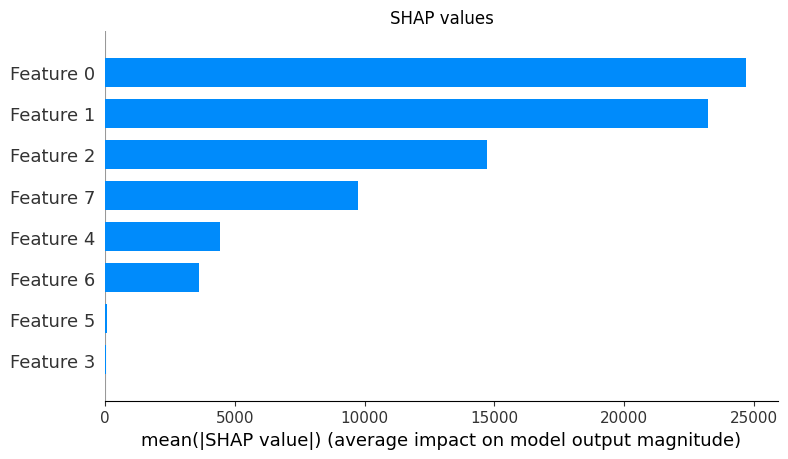

In [ ]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)
#Lo de Feature 0, 1, 2...Son las variables estandarizadas. Para que esto no pase hay que hacerlo con los datos normales, sin estandarizar.
#Me refiero que si lo que quiero ver son las variables en vez de lo de Feature 0,1 ...lo que hay que ahcer es NO estandarizar los datos

Los SHAP values nos indican ademas el sentido del impacto que tiene la variable en la predicción (positivo/negativo):
* Rojo a la derecha = POSITIVO (+)
* Rojo a la izquierda = NEGATIVO (-)

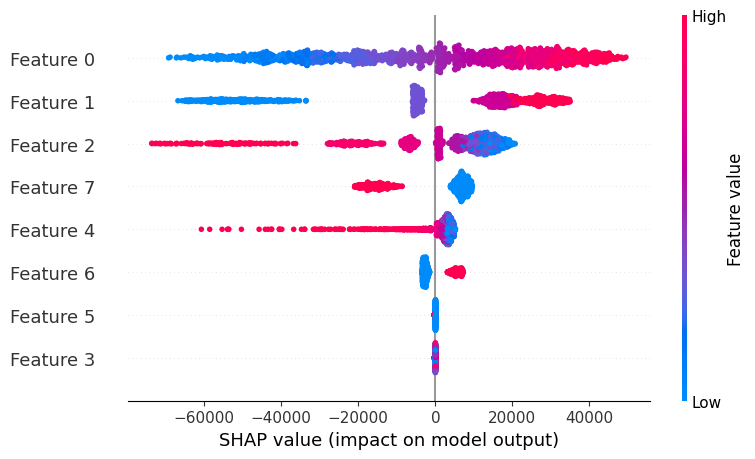

In [ ]:
shap.summary_plot(shap_values, X_test)
#Vemos que la variable Feature 3 (tam_buzon) no influye casi nada en el precio, por eso está en el 0.
#En cambio, la varianle Feature 0 (superficie) influye mucho tanto positivamente como negativamente.

# Deployment

## predicción de nuevos datos

In [ ]:
predicciones = modelo.predict(X_predecir)

In [ ]:
predicciones

array([329074.4158421 , 228458.08623935, 191817.78688451])

In [ ]:
df_predicciones = pd.DataFrame()

In [ ]:
df_predicciones['id_vivienda'] = id_viv_predecir
df_predicciones['precio'] = predicciones
df_predicciones

,id_vivienda,precio
7000,viv_7001,329074.415842
7001,viv_7002,228458.086239
7002,viv_7003,191817.786885
